##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/image_captioning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Setup

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8

zsh:1: command not found: apt


In [2]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.9.0
Uninstalling keras-3.9.0:
  Successfully uninstalled keras-3.9.0


In [6]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets tensorflow_hub

In [4]:
!pip install einops

This tutorial uses lots of imports, mostly for loading the dataset(s).

In [7]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

## [Optional] Data handling

This section downloads a captions dataset and prepares it for training. It tokenizes the input text, and caches the results of running all the images through a pretrained feature-extractor model. It's not critical to understand everything in this section.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Choose a dataset

This tutorial is set up to give a choice of datasets. Either [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) or a small slice of the [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset. These two are downloaded and converted from scratch, but it wouldn't be hard to convert the tutorial to use the caption datasets available in [TensorFlow Datasets](https://www.tensorflow.org/datasets): [Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) and the full [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions).


#### Flickr8k

In [ ]:
import shutil
import os

s = 'fol1'  # source directory
d = 'fol2'  # destination directory

if not os.path.exists(d):
    shutil.copytree(s, d)
else:
    print("Already exists")

In [47]:
import shutil
import os
    
def moveFiles(source_dir, target_dir):
    file_names = os.listdir(source_dir)
        
    for file_name in file_names:
        if file_name=='__MACOSX':
            continue
        shutil.move(os.path.join(source_dir, file_name), target_dir)

In [48]:
def flickr8k(path='flickr8k'):
  import shutil
  import os

  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    
    moveFiles(str(path)+'/Flickr8k_Dataset.zip', str(path))
    
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    
    moveFiles(str(path)+'/Flickr8k_text.zip', str(path))

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

#### Conceptual Captions

In [23]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path
    
    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)
    
    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

#### Download the dataset

The Flickr8k is a good choice because it contains 5-captions per image, more data for a smaller download.

In [191]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

choose = 'flickr8k'
# choose = 'flickr8k2324'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

The loaders for both datasets above return `tf.data.Dataset`s containing `(image_path, captions)` pairs. The Flickr8k dataset contains 5 captions per image, while Conceptual Captions has 1:

In [192]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [193]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [194]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

Here's a function to load an image and resize it for the model:

In [195]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [196]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [197]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [198]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [199]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

2025-05-03 20:35:58.951838: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [200]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('in'),
 np.str_('the'),
 np.str_('on'),
 np.str_('is'),
 np.str_('and')]

In [201]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [202]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [203]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [204]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [205]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [206]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [207]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [208]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [209]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [210]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [69]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [70]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

188it [01:40,  1.88it/s]
32it [00:15,  2.10it/s]


 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [211]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [212]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [213]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 18)
(32, 18)


The input tokens and the labels are the same, just shifted by 1 step:

In [214]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3   14   63    5   15  614   18   35 2021 1844    0    0    0    0
    0    0    0    0]
[  14   63    5   15  614   18   35 2021 1844    4    0    0    0    0
    0    0    0    0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [215]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [216]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [227]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, depth):
    super().__init__()
    self.d_model = depth
    self.embedding = tf.keras.layers.Embedding(vocab_size, depth, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=depth)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [218]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [219]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [220]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [221]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [222]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [223]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:03<00:00, 273.18it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [228]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.max_length = max_length

    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    # self.seq_embedding = SeqEmbedding(
    #     vocab_size=tokenizer.vocabulary_size(),
    #     depth=units,
    #     max_length=max_length)
    
    self.seq_embedding = PositionalEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [229]:
@Captioner.add_method
def call(self, inputs):
  image, txt = inputs

  if image.shape[-1] == 3:
    # Apply the feature-extractor, if you get an RGB image.
    image = self.feature_extractor(image)
  
  # Flatten the feature map
  image = einops.rearrange(image, 'b h w c -> b (h w) c')


  if txt.dtype == tf.string:
    # Apply the tokenizer if you get string inputs.
    txt = tokenizer(txt)

  txt = self.seq_embedding(txt)

  # Look at the image
  for dec_layer in self.decoder_layers:
    txt = dec_layer(inputs=(image, txt))
    
  txt = self.output_layer(txt)

  return txt

In [230]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, max_length=100, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [231]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [173]:
# @Captioner.add_method
# def simple_gen(self, image, temperature=1):
#   initial = self.word_to_index([['[START]']]) # (batch, sequence)
#   img_features = self.feature_extractor(image[tf.newaxis, ...])

#   tokens = initial # (batch, sequence)

#   for n in range(50):
#     preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
#     preds = preds[:,-1, :]  #(batch, vocab)
#     if temperature==0:
#         next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
#     else:
#         next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)

#     tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

#     if next[0] == self.word_to_index('[END]'):
#       break

#   words = index_to_word(tokens[0, 1:-1])
#   result = tf.strings.reduce_join(words, axis=-1, separator=' ')
#   return result.numpy().decode()

In [269]:
@Captioner.add_method
def simple_gen(self, image, temperature=1, desired_sentences=5):

  initial = self.word_to_index([['[START]']]) # (batch, sequence)

  initial = self.word_to_index([['[START]', 'the', 'man', 'wearing']]) # (batch, sequence)

  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  current_tokens = initial
  sentence_count = 0

  for n in range(self.max_length):
    preds = self((img_features, current_tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)

    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)
    current_tokens = tf.concat([current_tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      sentence_count += 1
      # current_tokens = initial

      if sentence_count >= desired_sentences:
        break

  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [270]:
for t in (0.0, 0.3, 0.4, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'causal_self_attention_8' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'decoder_layer_8' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


the man wearing a red and white helmet is riding a wave [END] in the ocean [END] [END] [END]
the man wearing a black wetsuit is surfing [END] a wave [END] in the ocean [END] [END]
the man wearing a red helmet is on a wave [END] in the water [END] [END] [END]
the man wearing a red surfboard is airborne [END] man in the ocean [END] [END] [END]


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [234]:
def masked_loss(labels, preds):  
  # print(labels)
  labels = tf.cast(labels, tf.int64)

  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [235]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [236]:
g = GenerateText()
g._model = model
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
with standing a a [END] white [END] a a a in in
white large skateboarder and field snow running a white large war a a posing front a posters a skier [END] in is with water in [END] group the little in swimming towards with a a trick



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [237]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [238]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [249]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 3.0719 - masked_acc: 0.4022

a man in a yellow shirt is swimming in the water [END] a man in a yellow shirt is swimming in the water [END] a man in a yellow shirt is swimming in the water [END] a man in a yellow shirt is swimming in the water [END] a man in a yellow shirt is swimming in the water
a skier is wearing a blue swimming pool [END] a man is in a water wave [END] a man in a yellow wetsuit is surfing [END] a man with a yellow surfboard is in a wave [END] a person in a blue coat and yellow shirt is is playing in the water
a young boy his hair is blowing in the dance [END] a man with a person 3 nears his take up on a man and blue are [END] man is digging in the distance is secured into the swimming [END] a girl boy in a wave [END] man in a wetsuit is swimming in the water

100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 498ms/step - loss: 3.0717 - masked_acc: 0.4022 - val_loss: 3.1244 - val_masked_acc: 0.3880
Epoch 2/100
100/100 ━━━

In [135]:
model.save("image_captioning_model.keras")

Plot the loss and accuracy over the training run:

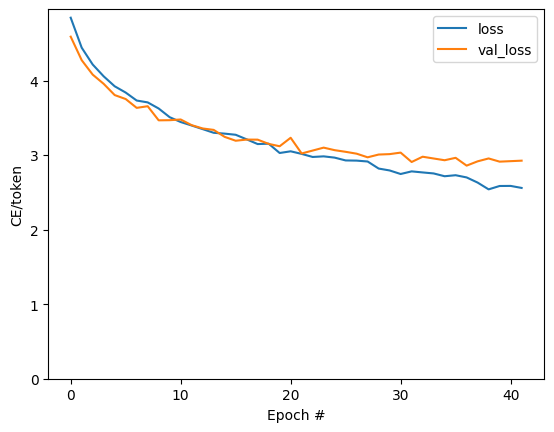

In [121]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

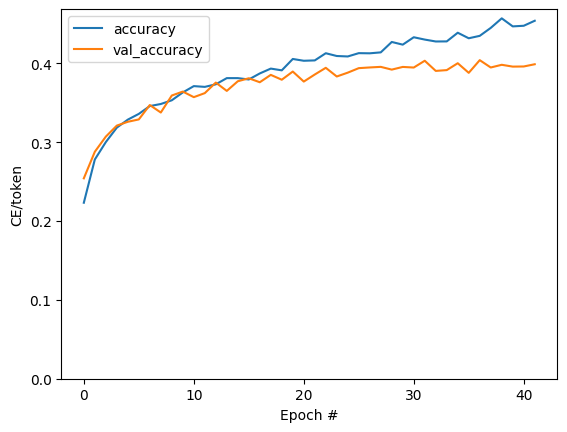

In [122]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [164]:
image = load_image('./6077092a74da0300181e19ec.jpg')
# image = load_image('./cat.jpg')

In [166]:
result = model.simple_gen(image, temperature=0.0)
result

'a group of children playing with a large and children'

Split the output back into tokens:

In [124]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [125]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 15, 49]), TensorShape([1, 2, 15, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [126]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [127]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([1.        , 0.99999994, 1.        , 1.        , 1.0000001 ,
       1.        , 0.99999994, 0.99999994, 1.        , 1.        ,
       0.9999999 , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [128]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

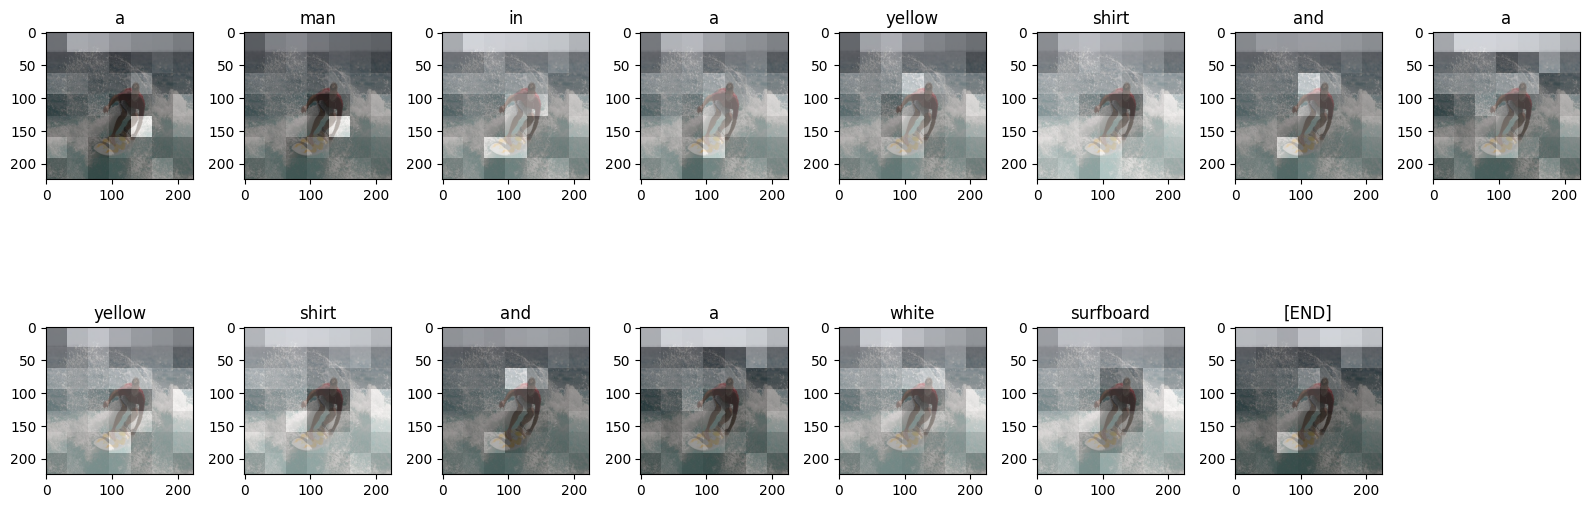

In [129]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [153]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


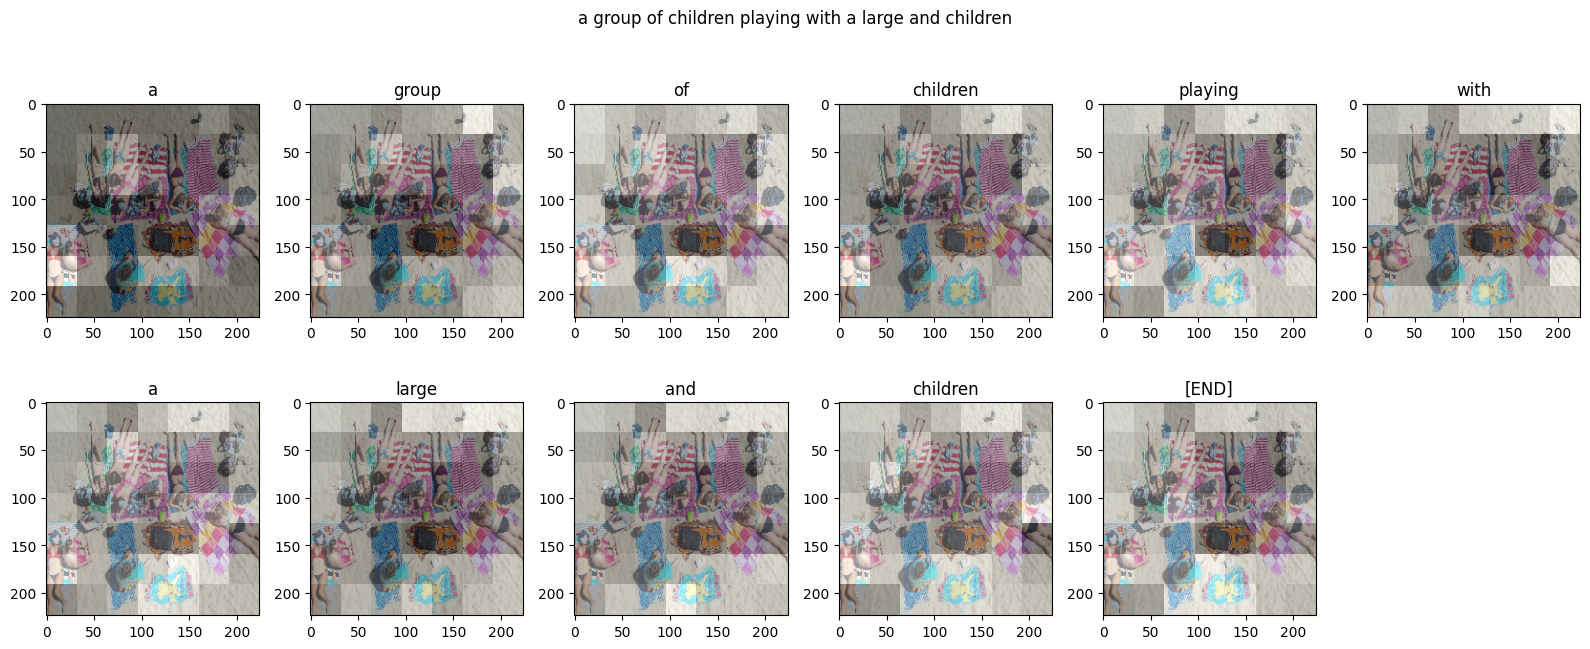

In [154]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


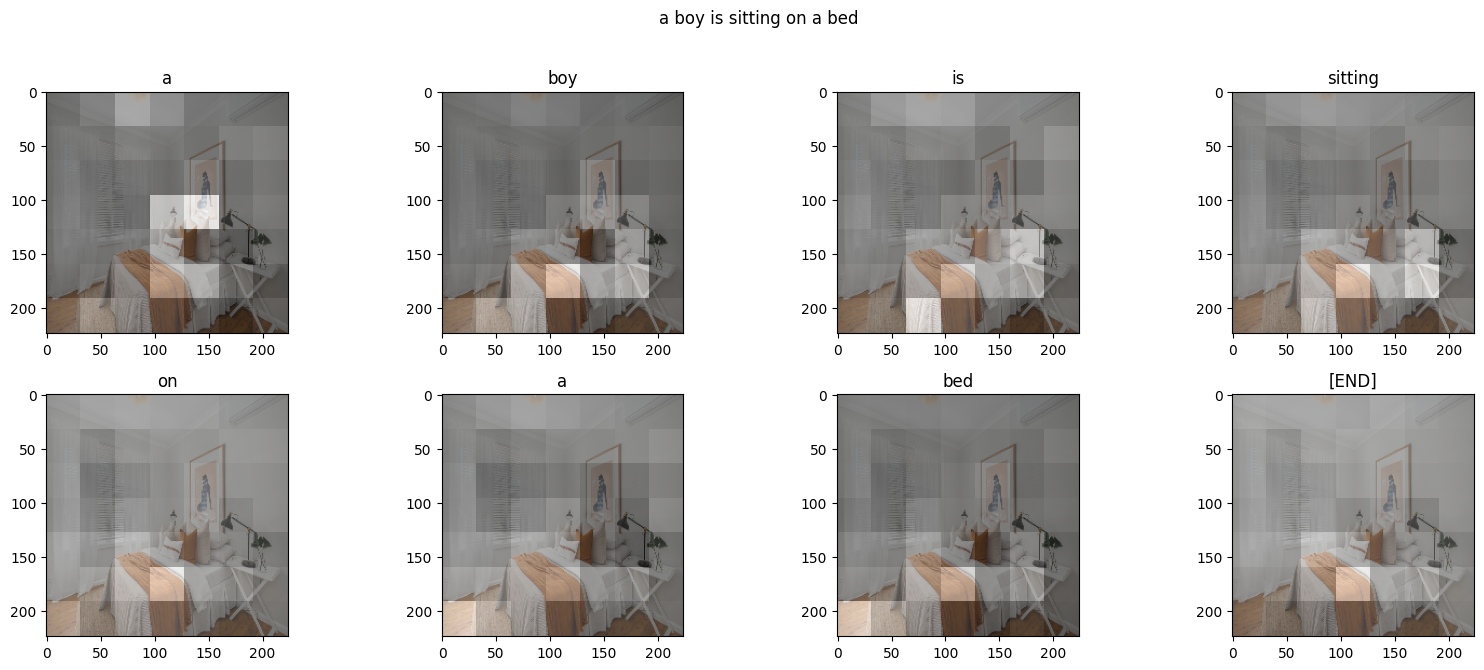

In [155]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)

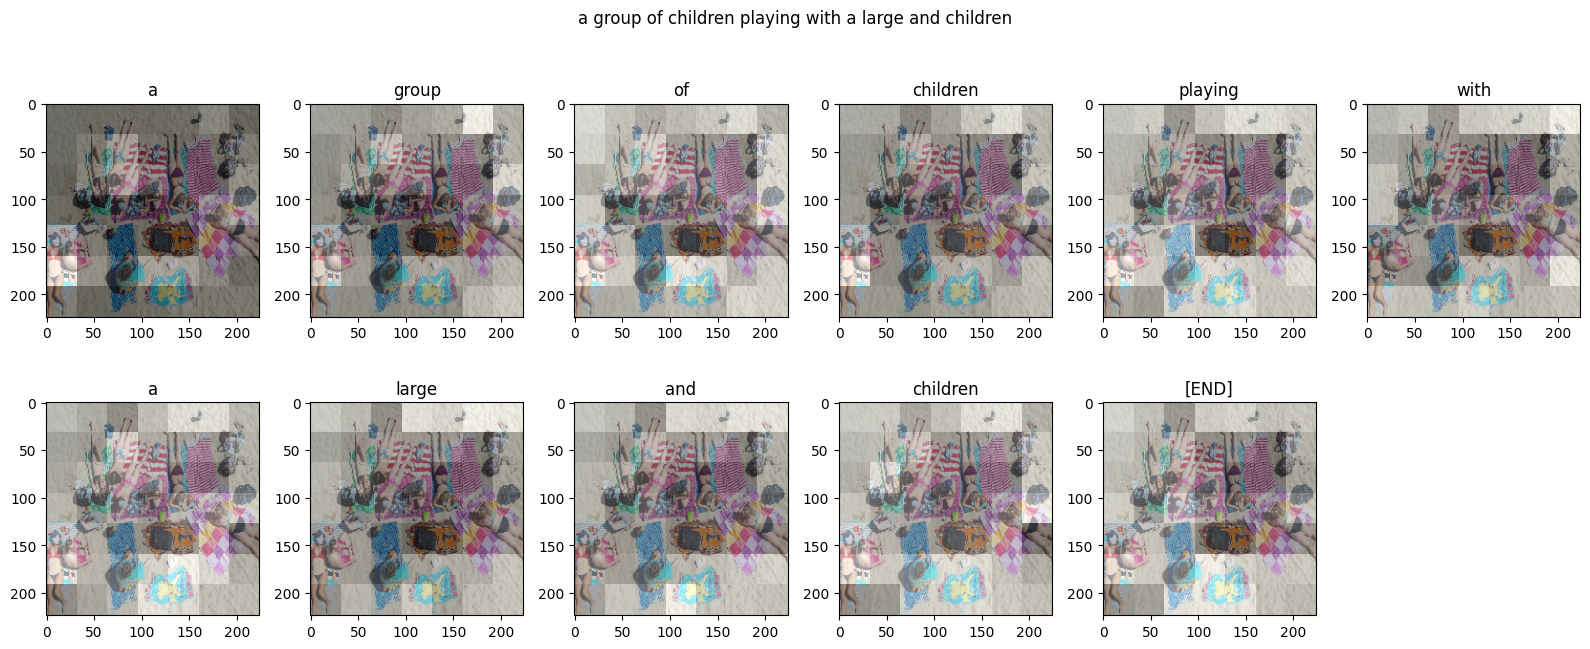

In [156]:
image = load_image('./6077092a74da0300181e19ec.jpg')

run_and_show_attention(model, image)